<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/simplify-cols/Steel%20Scrap%20Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [1]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip -d {PATH}

--2020-06-17 17:31:01--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2552121 (2.4M) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>]   2.43M  --.-KB/s    in 0.1s    

2020-06-17 17:31:02 (17.7 MB/s) - ‘/content/data/raw.zip’ saved [2552121/2552121]

Archive:  /content/data/raw.zip
   creating: /content/data/raw/
  inflating: /content/data/raw/CSF EOI.xlsx  
  inflating: /content/data/raw/CSF TV.xlsx  
  inflating: /content/data/raw/HC Closing Prices.xlsx  
  inflating: /content/data/raw/HC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HU Closing Prices.xlsx  
  inflating: /content/data/raw/HU Final Settlemen

## Load dataset

In [3]:
def st_to_mt(st):
  return st/1.10231131

Load Price data

In [4]:
# por ahora solo SC y SR
ignore = ['HU', 'HC', 'AM', 'UP']

In [25]:
p = PATH+'raw/*Closing Prices.xlsx'
excels = glob.glob(p)

frames = {}

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if name in ignore: continue
  if name == 'HU':
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in d.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    d[cols] = d[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    d.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  d.columns = ['Date'] + [name+'_'+c for c in d.columns if c != 'USD/mt']
  
  frames[name] = d

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames.values()]
price_df = pd.concat(dfs, axis=1)

price_df.head()

,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-23,338.0,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-24,337.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0
2015-11-25,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-26,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0
2015-11-27,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0


In [27]:
p = PATH+'raw/CSF*.xlsx'

excels = glob.glob(p)

for xcel in excels:
  d = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  name = os.path.basename(xcel)[-8:-5].strip()
  d[['HU']] = d[['HU']].apply(st_to_mt, axis=1)
  # Cambiamos el nombre a la columna
  d.drop(ignore, axis=1, inplace=True)
  rest = [c for c in d.columns if c != 'Date']
  d.rename(dict(zip(rest, [name+'_'+c for c in rest])), axis=1, inplace=True)

  frames[name] = d

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames.values()]
vol_df = pd.concat(dfs, axis=1)

vol_df.head()

,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,TV_SC,TV_SR,EOI_SC,EOI_SR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-23,338.0,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,333.5,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,NaN,NaN,NaN,NaN
2015-11-24,337.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,195.0,NaN,NaN,NaN,NaN
2015-11-25,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,195.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,NaN,NaN,NaN,NaN
2015-11-26,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,NaN,NaN,NaN,NaN
2015-11-27,334.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,335.0,192.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,NaN,NaN,NaN,NaN


In [7]:
all_df = pd.concat([price_df, vol_df], axis=1)

In [8]:
# Contamos los valores nulos del dataset -> 0
all_df.isnull().sum().sum()

1689

In [9]:
# por ahora eliminamos los nulos
all_df = all_df.dropna()
print(all_df.shape)
# Cuando empezamos a tener todos los valores -> 2017-01-04
all_df.index[0]

(761, 34)


Timestamp('2017-01-04 00:00:00')

In [10]:
all_df.head()

,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,TV_SC,TV_SR,EOI_SC,EOI_SR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,442.0,445.0,441.0,439.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.0,299.0,288.0,280.0,275.0,273.5,271.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,172.0,144.0,2186.0,329.0
2017-01-05,435.5,447.0,444.5,442.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.5,299.0,287.0,282.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,954.0,174.0,2486.0,374.0
2017-01-06,435.0,443.5,439.0,435.5,433.0,430.0,433.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.5,297.0,286.0,283.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,1038.0,123.0,2486.0,397.0
2017-01-09,435.0,439.5,437.0,434.5,433.0,430.0,433.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,295.0,297.0,290.0,288.0,280.0,270.0,270.0,269.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,708.0,57.0,2429.0,412.0
2017-01-10,435.0,444.5,445.0,441.0,433.0,436.0,433.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,297.0,300.0,295.0,289.0,287.5,280.0,275.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,2012.0,121.0,2776.0,397.0


# Data visualization

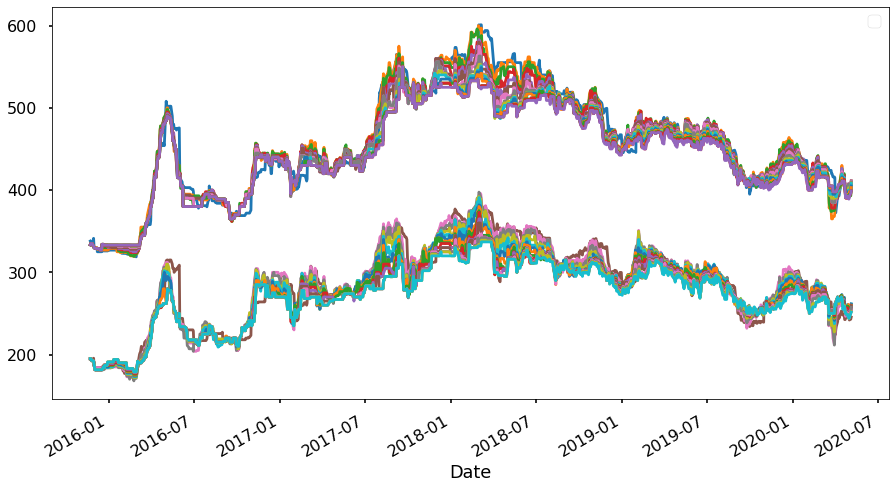

In [11]:
fig, ax = subplots()
price_df.plot(figsize=(15,8), ax=ax)
ax.legend([]);

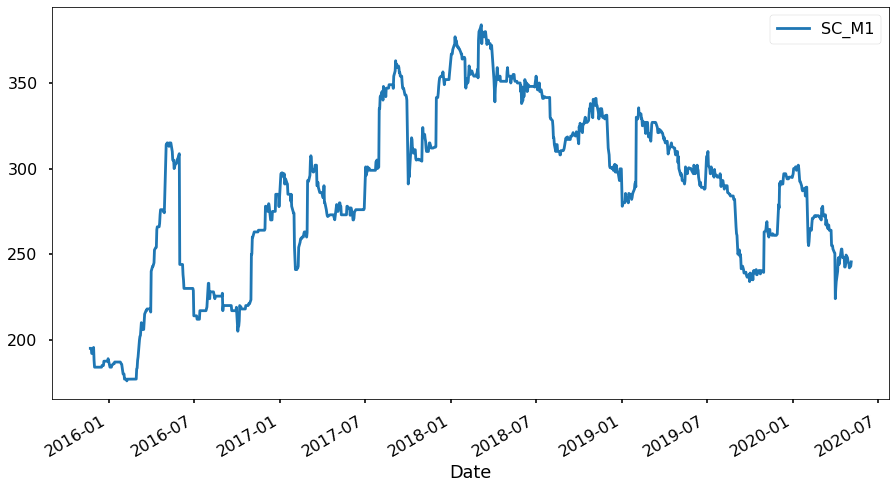

In [12]:
price_df[['SC_M1']].plot(figsize=(15,8))

# Model

In [13]:
to_predict = 'SC_M1'
data = all_df.reset_index().copy()
#data = data[['Date', to_predict]]

In [14]:
def add_caps(d1, d2=None, c='y'):
  if d2 is None:
    d2 = d1
  d2['cap'] = d1[c].max()
  d2['floor'] = d1[c].min()
  return d2

In [37]:
def simplify_df(dff):
  dff = dff.copy()
  
  print(dff.columns)
  exclude = ['Date', 'TV', 'EOI']
  cols = [c for c in dff.columns if all([x not in c for x in exclude])]
  firsts = [c for c in cols if '1' in c and len(c) <= 5]
  others = [c for c in cols if c not in firsts]
  #d = dict(zip(firsts, others))
  print(firsts)

  for r in rows:
    for k, v in d: # ??
      next_row = r + int(v[4:])
      dff.loc[next_row, k] = dff.loc[r, v]
  
  dff.drop(others, axis=1, inplace=True)
  return dff

gg = simplify_df(data)
gg.head()

Index(['Date', 'SR_M1', 'SR_M2', 'SR_M3', 'SR_M4', 'SR_M5', 'SR_M6', 'SR_M7',
       'SR_M8', 'SR_M9', 'SR_M10', 'SR_M11', 'SR_M12', 'SR_M13', 'SR_M14',
       'SR_M15', 'SC_M1', 'SC_M2', 'SC_M3', 'SC_M4', 'SC_M5', 'SC_M6', 'SC_M7',
       'SC_M8', 'SC_M9', 'SC_M10', 'SC_M11', 'SC_M12', 'SC_M13', 'SC_M14',
       'SC_M15', 'TV_SC', 'TV_SR', 'EOI_SC', 'EOI_SR'],
      dtype='object')
['SR_M1', 'SC_M1']


,Date,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,SC_M1,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,TV_SC,TV_SR,EOI_SC,EOI_SR
0,2017-01-04,442.0,445.0,441.0,439.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.0,299.0,288.0,280.0,275.0,273.5,271.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,172.0,144.0,2186.0,329.0
1,2017-01-05,435.5,447.0,444.5,442.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.5,299.0,287.0,282.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,954.0,174.0,2486.0,374.0
2,2017-01-06,435.0,443.5,439.0,435.5,433.0,430.0,433.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.5,297.0,286.0,283.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,1038.0,123.0,2486.0,397.0
3,2017-01-09,435.0,439.5,437.0,434.5,433.0,430.0,433.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,295.0,297.0,290.0,288.0,280.0,270.0,270.0,269.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,708.0,57.0,2429.0,412.0
4,2017-01-10,435.0,444.5,445.0,441.0,433.0,436.0,433.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,297.0,300.0,295.0,289.0,287.5,280.0,275.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,2012.0,121.0,2776.0,397.0


In [ ]:
def generate_model(dff):
  dff = dff.copy()
  # Esto es por si queremos filtrar datos para test
  fecha = '2015-03-11'

  others = [c for c in dff.columns if c not in ['Date', to_predict]]
  dff.rename({'Date': 'ds', to_predict: 'y'}, axis=1, inplace=True)

  dff = dff.loc[dff.ds > fecha]
  dff = add_caps(dff)
  modelo_futuro = Prophet(growth='linear', seasonality_mode='additive', yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
  for o in others:
    modelo_futuro.add_regressor(o)
  print('Added', len(others), 'regressors')
  return modelo_futuro, dff

In [ ]:
model, df_pred = generate_model(data)
df_pred.head()

Added 33 regressors


,ds,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
0,2017-01-04,442.0,445.0,441.0,439.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.0,299.0,288.0,280.0,275.0,273.5,271.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,172.0,144.0,2186.0,329.0,384.0,224.0
1,2017-01-05,435.5,447.0,444.5,442.0,438.0,438.0,438.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.5,299.0,287.0,282.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,954.0,174.0,2486.0,374.0,384.0,224.0
2,2017-01-06,435.0,443.5,439.0,435.5,433.0,430.0,433.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,435.0,297.5,297.0,286.0,283.0,272.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,1038.0,123.0,2486.0,397.0,384.0,224.0
3,2017-01-09,435.0,439.5,437.0,434.5,433.0,430.0,433.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,429.0,295.0,297.0,290.0,288.0,280.0,270.0,270.0,269.5,270.0,270.0,270.0,270.0,270.0,270.0,270.0,708.0,57.0,2429.0,412.0,384.0,224.0
4,2017-01-10,435.0,444.5,445.0,441.0,433.0,436.0,433.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,430.0,297.0,300.0,295.0,289.0,287.5,280.0,275.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,2012.0,121.0,2776.0,397.0,384.0,224.0


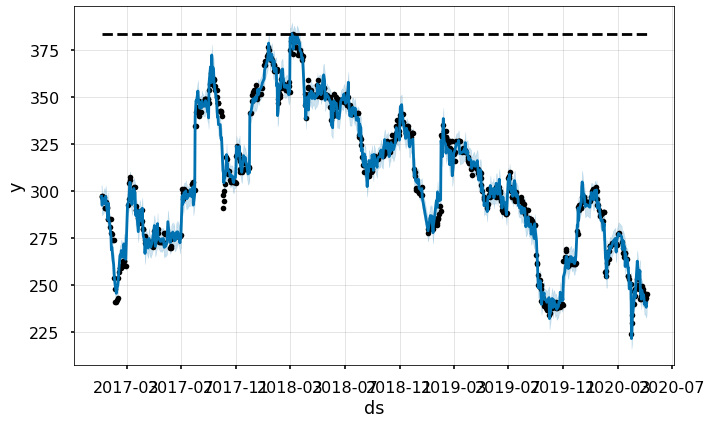

In [ ]:
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [ ]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: 98.58%


# Predict Future [EN PROCESO]

In [ ]:
# 3 more months from end of data
future = model.make_future_dataframe(periods=90, freq='d', include_history=False)
future = df_pred.append(future)
future = add_caps(df_pred, future)

In [ ]:
future.tail()

,ds,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
85,2020-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
86,2020-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
87,2020-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
88,2020-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0
89,2020-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0,224.0


In [ ]:
future.set_index(['ds'], inplace=True)

,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-31,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
2017-02-28,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2017-03-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2017-04-30,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2017-05-31,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16


In [ ]:
list(future.groupby([future.index.month]))[:2]

[(1,
               SR_M1  SR_M2  SR_M3  SR_M4  ...   EOI_SC  EOI_SR    cap  floor
  ds                                       ...                               
  2017-01-04  442.00  445.0  441.0  439.0  ...   2186.0   329.0  384.0  224.0
  2017-01-05  435.50  447.0  444.5  442.0  ...   2486.0   374.0  384.0  224.0
  2017-01-06  435.00  443.5  439.0  435.5  ...   2486.0   397.0  384.0  224.0
  2017-01-09  435.00  439.5  437.0  434.5  ...   2429.0   412.0  384.0  224.0
  2017-01-10  435.00  444.5  445.0  441.0  ...   2776.0   397.0  384.0  224.0
  ...            ...    ...    ...    ...  ...      ...     ...    ...    ...
  2020-01-27  436.50  424.5  432.0  430.0  ...  14435.0  3957.0  384.0  224.0
  2020-01-28  433.00  425.0  431.0  431.0  ...  14486.0  3982.0  384.0  224.0
  2020-01-29  434.00  428.0  430.0  430.0  ...  14513.0  3982.0  384.0  224.0
  2020-01-30  435.00  420.0  424.0  425.0  ...  14606.0  4022.0  384.0  224.0
  2020-01-31  436.06  418.0  421.0  422.0  ...  14638.0  40

In [ ]:
# Iterate through dates in batches of 30 days (1 month aprox) --> maybe 30.25??
# Substract amount of months since start
# assign corresponding data to batch rows

def fill_future(d, end):
  d = d.copy()
  d2 = d.loc[d.index > end].copy()
  last = d.loc[end]
  for n, m in list(d2.groupby([d2.index.month])):
    print('Month', n)
    diff = n - end.month
    print('Diff', diff)
    if diff == 0:
      m = last
    elif diff <= 15:
      m = d.loc[end, 'M'+diff]
    else:
      raise ValueError('Trying to predict more than 15 months!')
      return
    
    print(d2.loc[d2.index.month == n, :].head())
    d2.loc[d2.index.month == n, :] = m[d2.columns].values
    print(d2.loc[d2.index.month == n].head())
    
    break
  d.loc[d.index > end] = d2
  return d

full_future = fill_future(future, df_pred.ds.iloc[-1])

full_future.tail(91).head(32)

Month 5
Diff 0
            SR_M1  SR_M2  SR_M3  SR_M4  ...  EOI_SC  EOI_SR    cap  floor
ds                                      ...                              
2020-05-06    NaN    NaN    NaN    NaN  ...     NaN     NaN  384.0  224.0
2020-05-07    NaN    NaN    NaN    NaN  ...     NaN     NaN  384.0  224.0
2020-05-08    NaN    NaN    NaN    NaN  ...     NaN     NaN  384.0  224.0
2020-05-09    NaN    NaN    NaN    NaN  ...     NaN     NaN  384.0  224.0
2020-05-10    NaN    NaN    NaN    NaN  ...     NaN     NaN  384.0  224.0

[5 rows x 36 columns]
            SR_M1  SR_M2  SR_M3  SR_M4  ...   EOI_SC  EOI_SR    cap  floor
ds                                      ...                               
2020-05-06  402.0  405.0  408.5  410.0  ...  12034.0  2203.0  384.0  224.0
2020-05-07  402.0  405.0  408.5  410.0  ...  12034.0  2203.0  384.0  224.0
2020-05-08  402.0  405.0  408.5  410.0  ...  12034.0  2203.0  384.0  224.0
2020-05-09  402.0  405.0  408.5  410.0  ...  12034.0  2203.0  384.0  

,SR_M1,SR_M2,SR_M3,SR_M4,SR_M5,SR_M6,SR_M7,SR_M8,SR_M9,SR_M10,SR_M11,SR_M12,SR_M13,SR_M14,SR_M15,y,SC_M2,SC_M3,SC_M4,SC_M5,SC_M6,SC_M7,SC_M8,SC_M9,SC_M10,SC_M11,SC_M12,SC_M13,SC_M14,SC_M15,TV_SC,TV_SR,EOI_SC,EOI_SR,cap,floor
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-05,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-06,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-07,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-08,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-09,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-10,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-11,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-12,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0
2020-05-13,402.0,405.0,408.5,410.0,410.0,411.5,411.0,410.0,408.5,408.0,405.0,403.0,399.0,399.0,399.0,245.5,252.0,258.0,261.0,261.5,261.5,260.0,257.5,257.0,257.0,259.5,254.5,257.5,252.0,251.5,249.0,117.0,12034.0,2203.0,384.0,224.0


In [ ]:
future_forecast = model.predict(future)
fig = model.plot(future_forecast)

ValueError: ignored

In [ ]:
future_forecast['fact'] = future['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(future_forecast.fact, future_forecast.yhat)*100))

Accuracy: 99.05%
